### Imports

In [1]:
import numpy as np
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')

### Read and process data

In [2]:
data = open('input.txt', 'r').read()

Process data and calculate indexes

In [3]:
chars = list(set(data))
data_size, X_size = len(data), len(chars)
print("data has %d characters, %d unique" % (data_size, X_size))
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

data has 1115402 characters, 65 unique


### Constants and Hyperparameters

In [4]:
H_size = 100 # Size of the hidden layer
T_steps = 25 # Number of time steps (length of the sequence) used for training
learning_rate = 1e-1 # Learning rate
weight_sd = 0.1 # Standard deviation of weights for initialization
z_size = H_size + X_size # Size of concatenate(H, X) vector

### Activation Functions and Derivatives

#### Sigmoid

\begin{align}
\sigma(x) &= \frac{1}{1 + e^{-x}}\\
\frac{d\sigma(x)}{dx} &= \sigma(x) \cdot (1 - \sigma(x))
\end{align}

#### Tanh

\begin{align}
\frac{d\text{tanh}(x)}{dx} &= 1 - \text{tanh}^2(x)
\end{align}

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def dsigmoid(y):
    return y * (1 - y)


def tanh(x):
    return np.tanh(x)


def dtanh(y):
    return 1 - y * y

### Parameters

In [6]:
class Param:
    def __init__(self, name, value):
        self.name = name
        self.v = value #parameter value
        self.d = np.zeros_like(value) #derivative
        self.m = np.zeros_like(value) #momentum for AdaGrad

We use random weights with normal distribution (`0`, `weight_sd`) for $tanh$ activation function and (`0.5`, `weight_sd`) for $sigmoid$ activation function.

Biases are initialized to zeros.

In [7]:
class Parameters:
    def __init__(self):
        self.W_f = Param('W_f', 
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_f = Param('b_f',
                         np.zeros((H_size, 1)))

        self.W_i = Param('W_i',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_i = Param('b_i',
                         np.zeros((H_size, 1)))

        self.W_C = Param('W_C',
                         np.random.randn(H_size, z_size) * weight_sd)
        self.b_C = Param('b_C',
                         np.zeros((H_size, 1)))

        self.W_o = Param('W_o',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_o = Param('b_o',
                         np.zeros((H_size, 1)))

        #For final layer to predict the next character
        self.W_v = Param('W_v',
                         np.random.randn(X_size, H_size) * weight_sd)
        self.b_v = Param('b_v',
                         np.zeros((X_size, 1)))
        
    def all(self):
        return [self.W_f, self.W_i, self.W_C, self.W_o, self.W_v,
               self.b_f, self.b_i, self.b_C, self.b_o, self.b_v]
        
parameters = Parameters()

### Forward pass

![LSTM](http://blog.varunajayasiri.com/ml/lstm.svg)

*Operation $z$ is the concatenation of $x$ and $h_{t-1}$*

#### Concatenation of $h_{t-1}$ and $x_t$
\begin{align}
z & = [h_{t-1}, x_t] \\
\end{align}

#### LSTM functions
\begin{align}
f_t & = \sigma(W_f \cdot z + b_f) \\
i_t & = \sigma(W_i \cdot z + b_i) \\
\bar{C}_t & = tanh(W_C \cdot z + b_C) \\
C_t & = f_t * C_{t-1} + i_t * \bar{C}_t \\
o_t & = \sigma(W_o \cdot z + b_t) \\
h_t &= o_t * tanh(C_t) \\
\end{align}

#### Logits
\begin{align}
v_t &= W_v \cdot h_t + b_v \\
\end{align}

#### Softmax
\begin{align}
\hat{y_t} &= \text{softmax}(v_t)
\end{align}

$\hat{y_t}$ is `y` in code and $y_t$ is `targets`.


In [8]:
def forward(x, h_prev, C_prev, p = parameters):
    assert x.shape == (X_size, 1)
    assert h_prev.shape == (H_size, 1)
    assert C_prev.shape == (H_size, 1)
    
    z = np.row_stack((h_prev, x))
    f = sigmoid(np.dot(p.W_f.v, z) + p.b_f.v)
    i = sigmoid(np.dot(p.W_i.v, z) + p.b_i.v)
    C_bar = tanh(np.dot(p.W_C.v, z) + p.b_C.v)

    C = f * C_prev + i * C_bar
    o = sigmoid(np.dot(p.W_o.v, z) + p.b_o.v)
    h = o * tanh(C)

    v = np.dot(p.W_v.v, h) + p.b_v.v
    y = np.exp(v) / np.sum(np.exp(v)) #softmax

    return z, f, i, C_bar, C, o, h, v, y

### Backward pass

#### Loss

\begin{align}
L_k &= -\sum_{t=k}^T\sum_j y_{t,j} log \hat{y_{t,j}} \\
L &= L_1 \\
\end{align}

#### Gradients

\begin{align}
dv_t &= \hat{y_t} - y_t \\
dh_t &= dh'_t + W_y^T \cdot dv_t \\
do_t &= dh_t * \text{tanh}(C_t) \\
dC_t &= dC'_t + dh_t * o_t * (1 - \text{tanh}^2(C_t))\\
d\bar{C}_t &= dC_t * i_t \\
di_t &= dC_t * \bar{C}_t \\
df_t &= dC_t * C_{t-1} \\
\\
df'_t &= f_t * (1 - f_t) * df_t \\
di'_t &= i_t * (1 - i_t) * di_t \\
d\bar{C}'_{t-1} &= (1 - \bar{C}_t^2) * d\bar{C}_t \\
do'_t &= o_t * (1 - o_t) * do_t \\
dz_t &= W_f^T \cdot df'_t \\
     &+ W_i^T \cdot di_t \\
     &+ W_C^T \cdot d\bar{C}_t \\
     &+ W_o^T \cdot do_t \\
\\
[dh'_{t-1}, dx_t] &= dz_t \\
dC'_t &= f_t * dC_t
\end{align}

* $dC'_t = \frac{\partial L_{t+1}}{\partial C_t}$ and $dh'_t = \frac{\partial L_{t+1}}{\partial h_t}$
* $dC_t = \frac{\partial L}{\partial C_t} = \frac{\partial L_t}{\partial C_t}$ and $dh_t = \frac{\partial L}{\partial h_t} = \frac{\partial L_{t}}{\partial h_t}$
* All other derivatives are of $L$
* `target` is target character index $y_t$
* `dh_next` is $dh'_{t}$ (size H x 1)
* `dC_next` is $dC'_{t}$ (size H x 1)
* `C_prev` is $C_{t-1}$ (size H x 1)
* $df'_t$, $di'_t$, $d\bar{C}'_t$, and $do'_t$ are *also* assigned to `df`, `di`, `dC_bar`, and `do` in the **code**.
* *Returns* $dh_t$ and $dC_t$

#### Model parameter gradients

\begin{align}
dW_v &= dv_t \cdot h_t^T \\
db_v &= dv_t \\
\\
dW_f &= df'_t \cdot z^T \\
db_f &= df'_t \\
\\
dW_i &= di'_t \cdot z^T \\
db_i &= di'_t \\
\\
dW_C &= d\bar{C}'_t \cdot z^T \\
db_C &= d\bar{C}'_t \\
\\
dW_o &= do'_t \cdot z^T \\
db_o &= do'_t \\
\\
\end{align}

In [9]:
def backward(target, dh_next, dC_next, C_prev,
             z, f, i, C_bar, C, o, h, v, y,
             p = parameters):
    
    assert z.shape == (X_size + H_size, 1)
    assert v.shape == (X_size, 1)
    assert y.shape == (X_size, 1)
    
    for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
        assert param.shape == (H_size, 1)
        
    dv = np.copy(y)
    dv[target] -= 1

    p.W_v.d += np.dot(dv, h.T)
    p.b_v.d += dv

    dh = np.dot(p.W_v.v.T, dv)        
    dh += dh_next
    do = dh * tanh(C)
    do = dsigmoid(o) * do
    p.W_o.d += np.dot(do, z.T)
    p.b_o.d += do

    dC = np.copy(dC_next)
    dC += dh * o * dtanh(tanh(C))
    dC_bar = dC * i
    dC_bar = dtanh(C_bar) * dC_bar
    p.W_C.d += np.dot(dC_bar, z.T)
    p.b_C.d += dC_bar

    di = dC * C_bar
    di = dsigmoid(i) * di
    p.W_i.d += np.dot(di, z.T)
    p.b_i.d += di

    df = dC * C_prev
    df = dsigmoid(f) * df
    p.W_f.d += np.dot(df, z.T)
    p.b_f.d += df

    dz = (np.dot(p.W_f.v.T, df)
         + np.dot(p.W_i.v.T, di)
         + np.dot(p.W_C.v.T, dC_bar)
         + np.dot(p.W_o.v.T, do))
    dh_prev = dz[:H_size, :]
    dC_prev = f * dC
    
    return dh_prev, dC_prev

### Forward Backward Pass

Clear gradients before each backward pass

In [10]:
def clear_gradients(params = parameters):
    for p in params.all():
        p.d.fill(0)

Clip gradients to mitigate exploding gradients

In [11]:
def clip_gradients(params = parameters):
    for p in params.all():
        np.clip(p.d, -1, 1, out=p.d)

Calculate and store the values in forward pass. Accumulate gradients in backward pass and clip gradients to avoid exploding gradients.

* `input`, `target` are list of integers, with character indexes.
* `h_prev` is the array of initial `h` at $h_{-1}$ (size H x 1)
* `C_prev` is the array of initial `C` at $C_{-1}$ (size H x 1)
* *Returns* loss, final $h_T$ and $C_T$

In [12]:
def forward_backward(inputs, targets, h_prev, C_prev):
    global paramters
    
    # To store the values for each time step
    x_s, z_s, f_s, i_s,  = {}, {}, {}, {}
    C_bar_s, C_s, o_s, h_s = {}, {}, {}, {}
    v_s, y_s =  {}, {}
    
    # Values at t - 1
    h_s[-1] = np.copy(h_prev)
    C_s[-1] = np.copy(C_prev)
    
    loss = 0
    # Loop through time steps
    assert len(inputs) == T_steps
    for t in range(len(inputs)):
        x_s[t] = np.zeros((X_size, 1))
        x_s[t][inputs[t]] = 1 # Input character
        
        (z_s[t], f_s[t], i_s[t],
        C_bar_s[t], C_s[t], o_s[t], h_s[t],
        v_s[t], y_s[t]) = \
            forward(x_s[t], h_s[t - 1], C_s[t - 1]) # Forward pass
            
        loss += -np.log(y_s[t][targets[t], 0]) # Loss for at t
        
    clear_gradients()

    dh_next = np.zeros_like(h_s[0]) #dh from the next character
    dC_next = np.zeros_like(C_s[0]) #dh from the next character

    for t in reversed(range(len(inputs))):
        # Backward pass
        dh_next, dC_next = \
            backward(target = targets[t], dh_next = dh_next,
                     dC_next = dC_next, C_prev = C_s[t-1],
                     z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t],
                     C = C_s[t], o = o_s[t], h = h_s[t], v = v_s[t],
                     y = y_s[t])

    clip_gradients()
        
    return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]

### Sample the next character

In [13]:
def sample(h_prev, C_prev, first_char_idx, sentence_length):
    x = np.zeros((X_size, 1))
    x[first_char_idx] = 1

    h = h_prev
    C = C_prev

    indexes = []
    
    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = np.random.choice(range(X_size), p=p.ravel())
        x = np.zeros((X_size, 1))
        x[idx] = 1
        indexes.append(idx)

    return indexes

## Training (Adagrad)

Update the graph and display a sample output

In [14]:
def update_status(inputs, h_prev, C_prev):
    #initialized later
    global plot_iter, plot_loss
    global smooth_loss
    
    # Get predictions for 200 letters with current model

    sample_idx = sample(h_prev, C_prev, inputs[0], 200)
    txt = ''.join(idx_to_char[idx] for idx in sample_idx)

    # Clear and plot
    plt.plot(plot_iter, plot_loss)
    display.clear_output(wait=True)
    plt.show()

    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))
    print("iter %d, loss %f" % (iteration, smooth_loss))

Update parameters

\begin{align}
\theta_i &= \theta_i - \eta\frac{d\theta_i}{\sum dw_{\tau}^2} \\
d\theta_i &= \frac{\partial L}{\partial \theta_i}
\end{align}

In [15]:
def update_paramters(params = parameters):
    for p in params.all():
        p.m += p.d * p.d # Calculate sum of gradients
        #print(learning_rate * dparam)
        p.v += -(learning_rate * p.d / np.sqrt(p.m + 1e-8))

To delay the keyboard interrupt to prevent the training 
from stopping in the middle of an iteration 

In [16]:
import signal

class DelayedKeyboardInterrupt(object):
    def __enter__(self):
        self.signal_received = False
        self.old_handler = signal.signal(signal.SIGINT, self.handler)

    def handler(self, sig, frame):
        self.signal_received = (sig, frame)
        print('SIGINT received. Delaying KeyboardInterrupt.')

    def __exit__(self, type, value, traceback):
        signal.signal(signal.SIGINT, self.old_handler)
        if self.signal_received:
            self.old_handler(*self.signal_received)

In [17]:
# Exponential average of loss
# Initialize to a error of a random model
smooth_loss = -np.log(1.0 / X_size) * T_steps

iteration, pointer = 0, 0

# For the graph
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

Training loop

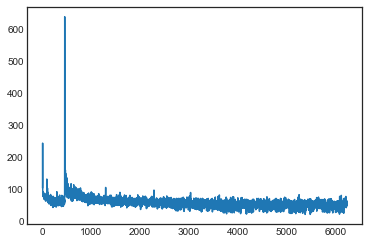

----
 .

MENENUS:
Rothy firertoud a to saken; brours Vulls hindss
Serrserd be claus kist yous surd your dondsther ums.

GMRUS:
with
And my itenten.

CORUDnd Toh ReDIUS:
Hald lim nod praki pat, lif haw wiviT 
----
iter 6231, loss 51.562062


In [18]:
while True:
    try:
        with DelayedKeyboardInterrupt():
            # Reset
            if pointer + T_steps >= len(data) or iteration == 0:
                g_h_prev = np.zeros((H_size, 1))
                g_C_prev = np.zeros((H_size, 1))
                pointer = 0


            inputs = ([char_to_idx[ch] 
                       for ch in data[pointer: pointer + T_steps]])
            targets = ([char_to_idx[ch] 
                        for ch in data[pointer + 1: pointer + T_steps + 1]])

            loss, g_h_prev, g_C_prev = \
                forward_backward(inputs, targets, g_h_prev, g_C_prev)
            smooth_loss = smooth_loss * 0.999 + loss * 0.001

            # Print every hundred steps
            if iteration % 100 == 0:
                update_status(inputs, g_h_prev, g_C_prev)

            update_paramters()

            plot_iter = np.append(plot_iter, [iteration])
            plot_loss = np.append(plot_loss, [loss])

            pointer += T_steps
            iteration += 1
    except KeyboardInterrupt:
        update_status(inputs, g_h_prev, g_C_prev)
        break

### Gradient Check

Approximate the numerical gradients by changing parameters and running the model. Check if the approximated gradients are equal to the computed analytical gradients (by backpropagation).

Try this on `num_checks` individual paramters picked randomly for each weight matrix and bias vector.

In [ ]:
from random import uniform

Calculate numerical gradient

In [ ]:
def calc_numerical_gradient(param, idx, delta, inputs, target, h_prev, C_prev):
    old_val = param.v.flat[idx]
    
    # evaluate loss at [x + delta] and [x - delta]
    param.v.flat[idx] = old_val + delta
    loss_plus_delta, _, _ = forward_backward(inputs, targets,
                                             h_prev, C_prev)
    param.v.flat[idx] = old_val - delta
    loss_mins_delta, _, _ = forward_backward(inputs, targets, 
                                             h_prev, C_prev)
    
    param.v.flat[idx] = old_val #reset

    grad_numerical = (loss_plus_delta - loss_mins_delta) / (2 * delta)
    # Clip numerical error because analytical gradient is clipped
    [grad_numerical] = np.clip([grad_numerical], -1, 1) 
    
    return grad_numerical

Check gradient of each paramter matrix/vector at `num_checks` individual values

In [ ]:
def gradient_check(num_checks, delta, inputs, target, h_prev, C_prev):
    global parameters
    
    # To calculate computed gradients
    _, _, _ =  forward_backward(inputs, targets, h_prev, C_prev)
    
    
    for param in parameters.all():
        #Make a copy because this will get modified
        d_copy = np.copy(param.d)

        # Test num_checks times
        for i in range(num_checks):
            # Pick a random index
            rnd_idx = int(uniform(0, param.v.size))
            
            grad_numerical = calc_numerical_gradient(param,
                                                     rnd_idx,
                                                     delta,
                                                     inputs,
                                                     target,
                                                     h_prev, C_prev)
            grad_analytical = d_copy.flat[rnd_idx]

            err_sum = abs(grad_numerical + grad_analytical) + 1e-09
            rel_error = abs(grad_analytical - grad_numerical) / err_sum
            
            # If relative error is greater than 1e-06
            if rel_error > 1e-06:
                print('%s (%e, %e) => %e'
                      % (param.name, grad_numerical, grad_analytical, rel_error))

In [ ]:
gradient_check(10, 1e-5, inputs, targets, g_h_prev, g_C_prev)